# TASK 1 : Convolutional-Recurrent Architectures

## Loading Dataframes 
### (Already preparaed in Data_WikiArt.ipynb)

In [1]:
import pandas as pd

IMAGE_FOLDER = r"/kaggle/input/wikiart"  

train_df = pd.read_csv("/kaggle/input/d/shiladityamondal/wikiart/train_dataset.csv",header = None, names=["file", "artist", "genre", "style"])

train_df["file"] = IMAGE_FOLDER + "/" + train_df["file"]

train_df.to_csv("image_dataset.csv", index=False)

val_df = pd.read_csv("/kaggle/input/d/shiladityamondal/wikiart/val_dataset.csv",header = None, names=["file", "artist", "genre", "style"])

val_df["file"] = IMAGE_FOLDER + "/" + val_df["file"]

val_df.to_csv("image_validation_dataset.csv", index=False)

print(train_df.shape)
print(val_df.shape)

(11276, 4)
(4707, 4)


## Data Cleaning

### Removing missing image files

In [2]:
import os

# Check if each file exists
missing_files = []
for index, row in train_df.iterrows():
    file_path = row['file']
    if not os.path.exists(file_path):
        missing_files.append(index)  # Store the indices of missing files
        print(missing_files)

# Remove rows with missing files
train_df = train_df.drop(missing_files)


# Check the final dataframe
print(train_df)


[7987]
[7987, 11258]
                                                    file  artist  genre  style
0      /kaggle/input/wikiart/Realism/vincent-van-gogh...      22      4     21
1      /kaggle/input/wikiart/Baroque/rembrandt_the-an...      20      7      4
2      /kaggle/input/wikiart/Post_Impressionism/paul-...      16      6     20
3      /kaggle/input/wikiart/Impressionism/pierre-aug...      17      2     12
4      /kaggle/input/wikiart/Art_Nouveau_Modern/boris...       1      2      3
...                                                  ...     ...    ...    ...
11271  /kaggle/input/wikiart/Cubism/pablo-picasso_sti...      15      9      7
11272  /kaggle/input/wikiart/Post_Impressionism/vince...      22      2     20
11273  /kaggle/input/wikiart/Impressionism/pierre-aug...      17      8     12
11274  /kaggle/input/wikiart/Northern_Renaissance/alb...       0      7     17
11275  /kaggle/input/wikiart/Realism/vincent-van-gogh...      22      8     21

[11274 rows x 4 columns]


In [3]:
import os

# Check if each file exists
missing_files = []
for index, row in val_df.iterrows():
    file_path = row['file']
    if not os.path.exists(file_path):
        missing_files.append(index)  # Store the indices of missing files

# Remove rows with missing files
val_df = val_df.drop(missing_files)

# Check the final dataframe
print(val_df)


                                                   file  artist  genre  style
0     /kaggle/input/wikiart/Impressionism/claude-mon...       4      4     12
1     /kaggle/input/wikiart/Impressionism/claude-mon...       4      1     12
2     /kaggle/input/wikiart/Impressionism/claude-mon...       4      2     12
3     /kaggle/input/wikiart/Impressionism/claude-mon...       4      1     12
4     /kaggle/input/wikiart/Impressionism/claude-mon...       4      1     12
...                                                 ...     ...    ...    ...
4702  /kaggle/input/wikiart/Cubism/pablo-picasso_two...      15      8      7
4703  /kaggle/input/wikiart/Symbolism/pablo-picasso_...      15      2     24
4704  /kaggle/input/wikiart/Expressionism/pablo-pica...      15      2      9
4705  /kaggle/input/wikiart/Expressionism/pablo-pica...      15      4      9
4706  /kaggle/input/wikiart/Cubism/pablo-picasso_cra...      15      9      7

[4707 rows x 4 columns]


## Tensorflow Dtaset Preparation

In [4]:
import tensorflow as tf

class_names = {
    "artist": {
        0: "Albrecht Durer", 1: "Boris Kustodiev", 2: "Camille Pissarro", 3: "Childe Hassam",
        4: "Claude Monet", 5: "Edgar Degas", 6: "Eugene Boudin", 7: "Gustave Dore",
        8: "Ilya Repin", 9: "Ivan Aivazovsky", 10: "Ivan Shishkin", 11: "John Singer Sargent",
        12: "Marc Chagall", 13: "Martiros Saryan", 14: "Nicholas Roerich", 15: "Pablo Picasso",
        16: "Paul Cezanne", 17: "Pierre Auguste Renoir", 18: "Pyotr Konchalovsky", 19: "Raphael Kirchner",
        20: "Rembrandt", 21: "Salvador Dali", 22: "Vincent van Gogh"
    },
    "genre": {
        0: "Abstract Painting", 1: "Cityscape", 2: "Genre Painting", 3: "Illustration",
        4: "Landscape", 5: "Nude Painting", 6: "Portrait", 7: "Religious Painting",
        8: "Sketch and Study", 9: "Still Life"
    },
    "style": {
        0: "Abstract Expressionism", 1: "Action Painting", 2: "Analytical Cubism", 3: "Art Nouveau",
        4: "Baroque", 5: "Color Field Painting", 6: "Contemporary Realism", 7: "Cubism",
        8: "Early Renaissance", 9: "Expressionism", 10: "Fauvism", 11: "High Renaissance",
        12: "Impressionism", 13: "Mannerism Late Renaissance", 14: "Minimalism",
        15: "Naive Art Primitivism", 16: "New Realism", 17: "Northern Renaissance",
        18: "Pointillism", 19: "Pop Art", 20: "Post Impressionism", 21: "Realism",
        22: "Rococo", 23: "Romanticism", 24: "Symbolism", 25: "Synthetic Cubism", 26: "Ukiyo-e"
    }
}

def preprocess_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Resize
    image = image / 255.0  # Normalize
    return image

def create_tf_dataset(df, sequence_length=10):
    filenames = df["file"].values
    artist_labels = df["artist"].values
    genre_labels = df["genre"].values
    style_labels = df["style"].values

    artist_labels = tf.keras.utils.to_categorical(artist_labels, num_classes=len(class_names['artist']))
    genre_labels = tf.keras.utils.to_categorical(genre_labels, num_classes=len(class_names['genre']))
    style_labels = tf.keras.utils.to_categorical(style_labels, num_classes=len(class_names['style']))

    ds = tf.data.Dataset.from_tensor_slices((filenames, artist_labels, genre_labels, style_labels))
    
    def load_data(filename, artist, genre, style):
        image = preprocess_image(filename)
        
        image_sequence = tf.repeat(tf.expand_dims(image, axis=0), sequence_length, axis=0)
        
        return image_sequence, {'artist': artist, 'genre': genre, 'style': style}
    
    ds = ds.map(load_data)
    ds = ds.batch(8).shuffle(100)

    return ds

train_dataset = create_tf_dataset(train_df)
val_dataset = create_tf_dataset(val_df)


for images, labels in train_dataset.take(1):
    print(images.shape) 
    print(labels['artist'].shape) 
    print(labels['genre'].shape)  
    print(labels['style'].shape) 
    
for images, labels in val_dataset.take(1):
    print(images.shape) 
    print(labels['artist'].shape) 
    print(labels['genre'].shape)  
    print(labels['style'].shape)  


(8, 10, 128, 128, 3)
(8, 23)
(8, 10)
(8, 27)
(8, 10, 128, 128, 3)
(8, 23)
(8, 10)
(8, 27)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(dataset, num_samples=8):
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):  
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            
            # Display the first image from the sequence (or select a random frame from the sequence)
            img_to_display = images[i][0].numpy()  # Select the first frame from the sequence
            plt.imshow(img_to_display)  
            plt.axis("off")

            # Use np.argmax to get the index of the highest value in the one-hot encoded vectors
            artist_label = class_names['artist'][np.argmax(labels['artist'][i].numpy())]
            genre_label = class_names['genre'][np.argmax(labels['genre'][i].numpy())]
            style_label = class_names['style'][np.argmax(labels['style'][i].numpy())]

            title = f"A: {artist_label}\nG: {genre_label}\nS: {style_label}"
            plt.title(title, fontsize=7)

        break  

    plt.show()



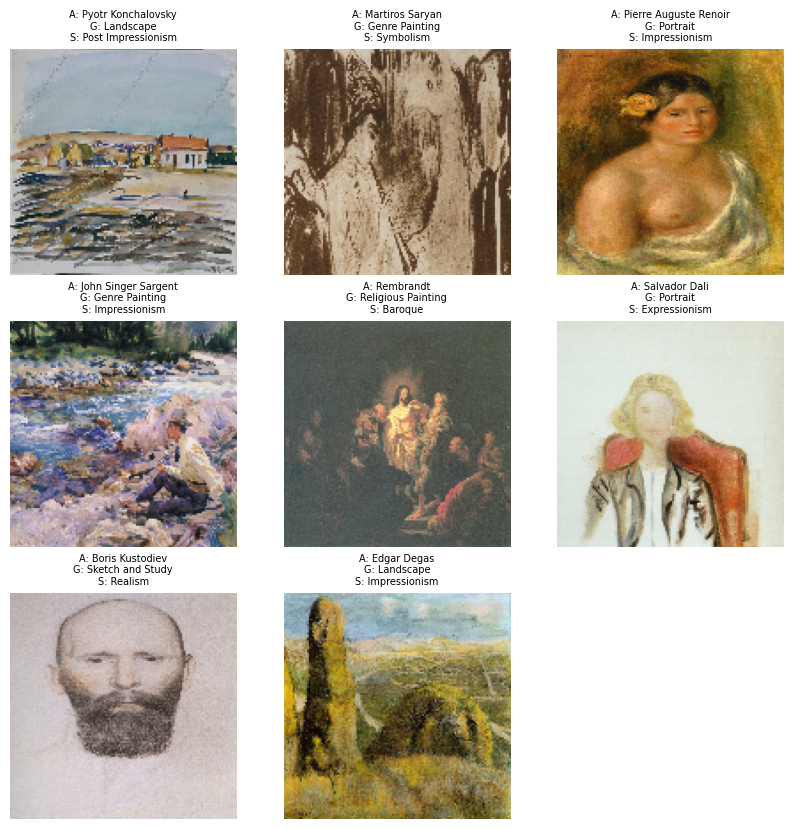

In [6]:
show_samples(train_dataset)

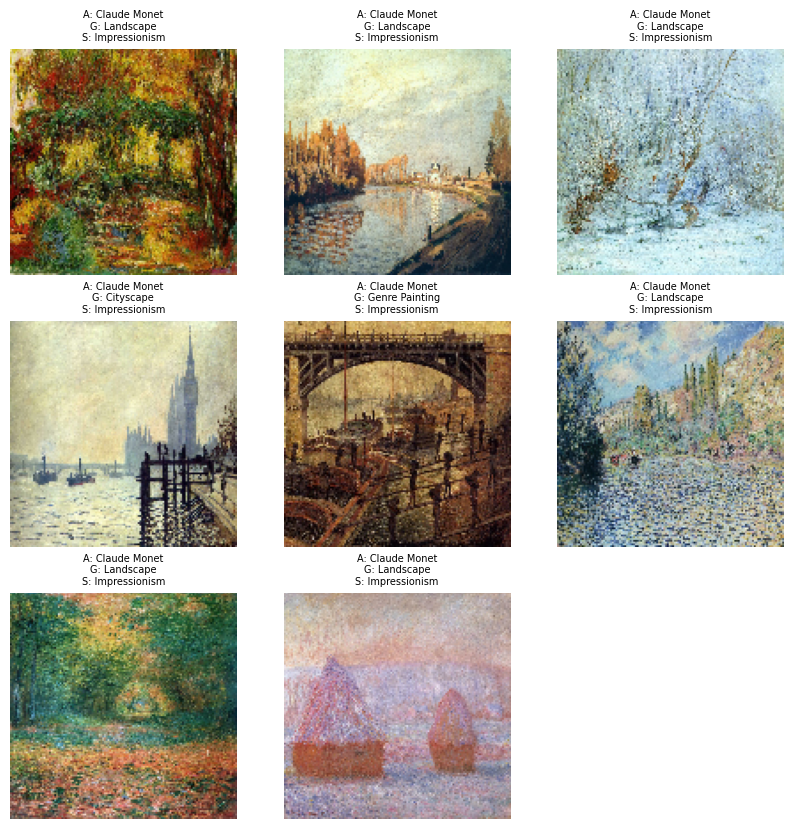

In [7]:
show_samples(val_dataset)

## APPROACH 

### Convolutional-Recurrent Architecture for Art Classification

### 1. **Input Layer**
   - It Accepts images of shape `(128, 128, 3)`, ensuring consistency in the dataset.

### 2. **Feature Extraction with ResNet50**
   - Pretrained `ResNet50` is used (without fully connected layers) to extract rich feature representations.
   - Intermediate feature maps are taken from `"conv4_block6_out"` (8×8×1024) to balance depth and computational efficiency.

### 3. **Channel Reduction**
   - A `1x1` convolution layer reduces the dimensionality of extracted features to `64` channels.
   - This helps reduce computational cost while retaining key features.

### 4. **Recurrent Convolutional Layers (RCL)**
   - **Why RCL?** Unlike traditional CNNs, RCL allows information to flow recurrently within convolutional layers, improving feature refinement.
   - Three sets of recurrent convolutions are applied, interleaved with `MaxPooling` layers to progressively reduce spatial dimensions.

### 5. **Transformer Attention Mechanism**
   - Flattened feature maps are passed through a `MultiHeadAttention` layer with `3` attention heads.
   - **Why Attention?** It helps model long-range dependencies and improves feature interactions, which is crucial for high-level artistic attributes.

### 6. **Global Feature Aggregation**
   - `GlobalMaxPooling1D` extracts the most significant features from the transformer-processed data.
   - This condenses information from multiple spatial regions into a compact representation.

### 7. **Multi-Task Classification**
   - **Three Fully Connected Layers** output probabilities for:
     - `Artist Classification` (23 classes)
     - `Genre Classification` (10 classes)
     - `Style Classification` (27 classes)
   - Each output branch uses `softmax` activation with `categorical_crossentropy` loss.

### 8. **Optimization and Training**
   - **Adam optimizer** with a learning rate of `0.0005` for stable convergence.
   - **Metrics:** Accuracy is used for all tasks to evaluate performance.

## Summary
This architecture effectively combines CNN-based feature extraction, recurrent refinement, and transformer-based attention to classify artworks based on `Artist`, `Genre`, and `Style`, leveraging the ArtGAN dataset.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Define Recurrent Convolutional Layer (RCL)
def RCL(x, filters, name):
    conv1 = layers.Conv2D(filters, kernel_size=3, padding="same", activation=None, name=f"{name}_conv1")(x)
    rcl1 = layers.Add(name=f"{name}_add1")([conv1, x])
    bn1 = layers.BatchNormalization(name=f"{name}_bn1")(rcl1)
    
    conv2 = layers.Conv2D(filters, kernel_size=3, padding="same", activation=None, name=f"{name}_conv2")(bn1)
    rcl2 = layers.Add(name=f"{name}_add2")([conv2, x])
    bn2 = layers.BatchNormalization(name=f"{name}_bn2")(rcl2)

    conv3 = layers.Conv2D(filters, kernel_size=3, padding="same", activation=None, name=f"{name}_conv3")(bn2)
    rcl3 = layers.Add(name=f"{name}_add3")([conv3, x])
    bn3 = layers.BatchNormalization(name=f"{name}_bn3")(rcl3)
    
    return layers.ReLU()(bn3)

# Define the model with ResNet, RCL, and Transformer Attention
def build_rcl_transformer_model(input_shape=(128, 128, 3), num_classes_artist=23, num_classes_genre=10, num_classes_style=27):
    inputs = layers.Input(shape=input_shape)

    # Use ResNet50 as a feature extractor (without FC layers)
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # Extract feature maps from an intermediate layer
    x = base_model.get_layer("conv4_block6_out").output  # Shape: (8, 8, 1024)

    # Reduce channel dimensions (optional)
    x = layers.Conv2D(64, kernel_size=1, activation="relu", padding="same", name="reduce_channels")(x)

    # Recurrent Convolution Blocks
    x = RCL(x, 64, "rcl1")
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="pool1")(x)

    x = RCL(x, 64, "rcl2")
    x = RCL(x, 64, "rcl3")
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="pool2")(x)

    x = RCL(x, 64, "rcl4")
    x = RCL(x, 64, "rcl5")

    # Flatten spatial features for transformer input
    x = layers.Reshape((-1, 64))(x)  # Shape: (batch, num_patches, channels)

    # Multi-Head Self-Attention with 3 Heads
    attn_output = layers.MultiHeadAttention(num_heads=3, key_dim=64, dropout=0.1, name="multihead_attn")(x, x)
    x = layers.Add()([x, attn_output])  # Residual Connection
    x = layers.LayerNormalization()(x)

    # Global Max Pooling to summarize attention output
    x = layers.GlobalMaxPooling1D()(x)

    # Fully Connected Layers for Classification
    artist_output = layers.Dense(num_classes_artist, activation="softmax", name="artist")(x)
    genre_output = layers.Dense(num_classes_genre, activation="softmax", name="genre")(x)
    style_output = layers.Dense(num_classes_style, activation="softmax", name="style")(x)

    # Build the model
    model = models.Model(inputs=inputs, outputs=[artist_output, genre_output, style_output], name="RCL_Transformer_Network")

    return model

# Create and compile the model
model = build_rcl_transformer_model()
model.compile(
    loss={'artist': 'categorical_crossentropy',
          'genre': 'categorical_crossentropy',
          'style': 'categorical_crossentropy'},
    optimizer=Adam(learning_rate=0.0005),
    metrics={'artist': ['accuracy'], 
             'genre': ['accuracy'], 
             'style': ['accuracy']}
)

# Print model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "RCL_Transformer_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 9,266,364 (35.35 MB)

 Trainable params: 9,233,852 (35.22 MB)

 Non-trainable params: 32,512 (127.00 KB)

In [9]:
import tensorflow as tf

class_names = {
    "artist": {
        0: "Albrecht Durer", 1: "Boris Kustodiev", 2: "Camille Pissarro", 3: "Childe Hassam",
        4: "Claude Monet", 5: "Edgar Degas", 6: "Eugene Boudin", 7: "Gustave Dore",
        8: "Ilya Repin", 9: "Ivan Aivazovsky", 10: "Ivan Shishkin", 11: "John Singer Sargent",
        12: "Marc Chagall", 13: "Martiros Saryan", 14: "Nicholas Roerich", 15: "Pablo Picasso",
        16: "Paul Cezanne", 17: "Pierre Auguste Renoir", 18: "Pyotr Konchalovsky", 19: "Raphael Kirchner",
        20: "Rembrandt", 21: "Salvador Dali", 22: "Vincent van Gogh"
    },
    "genre": {
        0: "Abstract Painting", 1: "Cityscape", 2: "Genre Painting", 3: "Illustration",
        4: "Landscape", 5: "Nude Painting", 6: "Portrait", 7: "Religious Painting",
        8: "Sketch and Study", 9: "Still Life"
    },
    "style": {
        0: "Abstract Expressionism", 1: "Action Painting", 2: "Analytical Cubism", 3: "Art Nouveau",
        4: "Baroque", 5: "Color Field Painting", 6: "Contemporary Realism", 7: "Cubism",
        8: "Early Renaissance", 9: "Expressionism", 10: "Fauvism", 11: "High Renaissance",
        12: "Impressionism", 13: "Mannerism Late Renaissance", 14: "Minimalism",
        15: "Naive Art Primitivism", 16: "New Realism", 17: "Northern Renaissance",
        18: "Pointillism", 19: "Pop Art", 20: "Post Impressionism", 21: "Realism",
        22: "Rococo", 23: "Romanticism", 24: "Symbolism", 25: "Synthetic Cubism", 26: "Ukiyo-e"
    }
}

# Preprocessing function (no sequence length)
def preprocess_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Resize to match model input
    image = image / 255.0  # Normalize to [0,1]
    return image

# Function to create TensorFlow dataset
def create_tf_dataset(df, batch_size=8):
    filenames = df["file"].values
    artist_labels = df["artist"].values
    genre_labels = df["genre"].values
    style_labels = df["style"].values

    artist_labels = tf.keras.utils.to_categorical(artist_labels, num_classes=len(class_names['artist']))
    genre_labels = tf.keras.utils.to_categorical(genre_labels, num_classes=len(class_names['genre']))
    style_labels = tf.keras.utils.to_categorical(style_labels, num_classes=len(class_names['style']))

    ds = tf.data.Dataset.from_tensor_slices((filenames, artist_labels, genre_labels, style_labels))
    
    def load_data(filename, artist, genre, style):
        image = preprocess_image(filename)
        return image, {'artist': artist, 'genre': genre, 'style': style}
    
    ds = ds.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).shuffle(100).prefetch(tf.data.AUTOTUNE)

    return ds

# Create train & validation datasets
train_dataset = create_tf_dataset(train_df)
val_dataset = create_tf_dataset(val_df)

# Print sample data shapes
for images, labels in train_dataset.take(1):
    print("Train Batch Shape:", images.shape)  # Expecting (batch_size, 128, 128, 3)
    print("Artist Label Shape:", labels['artist'].shape)  # (batch_size, num_classes)
    print("Genre Label Shape:", labels['genre'].shape)  
    print("Style Label Shape:", labels['style'].shape)  

for images, labels in val_dataset.take(1):
    print("Validation Batch Shape:", images.shape)  
    print("Artist Label Shape:", labels['artist'].shape)  
    print("Genre Label Shape:", labels['genre'].shape)  
    print("Style Label Shape:", labels['style'].shape)  

Train Batch Shape: (8, 128, 128, 3)
Artist Label Shape: (8, 23)
Genre Label Shape: (8, 10)
Style Label Shape: (8, 27)
Validation Batch Shape: (8, 128, 128, 3)
Artist Label Shape: (8, 23)
Genre Label Shape: (8, 10)
Style Label Shape: (8, 27)


In [11]:
import os
import numpy as np
from tensorflow.keras.callbacks import Callback

class SaveBestModel(Callback):
    def __init__(self, save_freq=20, save_dir='/kaggle/working/'):
        super(SaveBestModel, self).__init__()
        self.save_freq = save_freq
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  
        self.best_avg_val_acc = -np.inf 
        self.val_acc_history = [] 

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or 'val_artist_accuracy' not in logs or 'val_genre_accuracy' not in logs or 'val_style_accuracy' not in logs:
            return  # Ensure validation metrics exist

        # Compute the average validation accuracy for artist, genre, and style classification
        val_acc = np.mean([
            logs['val_artist_accuracy'],  
            logs['val_genre_accuracy'],  
            logs['val_style_accuracy']
        ])

        # Store validation accuracy history
        self.val_acc_history.append(val_acc)

        # Save model only every 'save_freq' epochs
        if (epoch + 1) % self.save_freq == 0:
            # Compute the moving average of the last 3 validation accuracies
            if len(self.val_acc_history) >= 3:
                avg_last_3_val_acc = np.mean(self.val_acc_history[-3:])

                # Save model only if this moving average is better than the previous best
                if avg_last_3_val_acc > self.best_avg_val_acc:
                    self.best_avg_val_acc = avg_last_3_val_acc
                    save_path = os.path.join(self.save_dir, f'best_model_epoch_{epoch+1}.h5')
                    self.model.save(save_path)
                    print(f"✅ Model saved at {save_path} with avg val acc: {avg_last_3_val_acc:.4f}")

# Example of training the model with SaveBestModel callback
history = model.fit(
    train_dataset,  
    epochs=100,
    steps_per_epoch=100,
    validation_data=val_dataset,  
    validation_steps=10,
    callbacks=[SaveBestModel(save_freq=20)]  
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - artist_accuracy: 0.3699 - artist_loss: 2.1510 - genre_accuracy: 0.4879 - genre_loss: 1.4587 - loss: 5.2695 - style_accuracy: 0.4685 - style_loss: 1.6597 - val_artist_accuracy: 0.3250 - val_artist_loss: 2.5000 - val_genre_accuracy: 0.5000 - val_genre_loss: 1.5370 - val_loss: 5.7170 - val_style_accuracy: 0.4375 - val_style_loss: 1.6800
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - artist_accuracy: 0.3476 - artist_loss: 2.2074 - genre_accuracy: 0.4790 - genre_loss: 1.4658 - loss: 5.1664 - style_accuracy: 0.5435 - style_loss: 1.4932 - val_artist_accuracy: 0.1375 - val_artist_loss: 2.9385 - val_genre_accuracy: 0.4875 - val_genre_loss: 1.4315 - val_loss: 6.2485 - val_style_accuracy: 0.1625 - val_style_loss: 1.8784
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - artist_accuracy: 0.3715 - artist_loss: 2.1414 - genre_accuracy: 0.5034 - genre_loss: 1.4019 - loss: 5.0287 - style_accuracy: 0.5233 - style_loss: 1.4854 - val_

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - artist_accuracy: 0.4270 - artist_loss: 1.8386 - genre_accuracy: 0.5552 - genre_loss: 1.2802 - loss: 4.4632 - style_accuracy: 0.5528 - style_loss: 1.3443 - val_artist_accuracy: 0.6125 - val_artist_loss: 1.5996 - val_genre_accuracy: 0.5125 - val_genre_loss: 1.2790 - val_loss: 3.8631 - val_style_accuracy: 0.7750 - val_style_loss: 0.9846
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - artist_accuracy: 0.4026 - artist_loss: 1.9334 - genre_accuracy: 0.5186 - genre_loss: 1.3322 - loss: 4.7070 - style_accuracy: 0.5111 - style_loss: 1.4413 - val_artist_accuracy: 0.2750 - val_artist_loss: 2.2181 - val_genre_accuracy: 0.4375 - val_genre_loss: 1.4108 - val_loss: 5.1051 - val_style_accuracy: 0.4875 - val_style_loss: 1.4761
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - artist_accuracy: 0.4549 - artist_loss: 1.9330 - genre_accuracy: 0.5411 - genre_loss: 1.2545 - loss: 4.5398 - style_accuracy: 0.5534 - style_loss: 1.3522 - val_artist_accu

## Evaluation on Validation/Test Set

In [17]:
import tensorflow as tf

# Load the trained model
model_path = r"/kaggle/working/best_model_epoch_100.h5"
model = tf.keras.models.load_model(model_path)

In [16]:
results = model.evaluate(val_dataset)
print(f"Evaluation Results: {results}")

589/589 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - artist_accuracy: 0.5142 - artist_loss: 1.5941 - genre_accuracy: 0.6142 - genre_loss: 1.1502 - loss: 3.7418 - style_accuracy: 0.6839 - style_loss: 0.9976
Evaluation Results: [4.145884037017822, 1.7166377305984497, 1.2067137956619263, 1.222962737083435, 0.4969194829463959, 0.6042065024375916, 0.6201401948928833]


###  **1.Evaluation Metrics Used**
To assess the performance of the model in classifying **Artist, Genre, and Style**, we use the following metrics:

### **Accuracy**
- Measures the percentage of correctly predicted labels.
- Used for each classification task (`Artist`, `Genre`, `Style`).
- **Strengths:** Easy to interpret, suitable for balanced datasets.
- **Limitations:** Can be misleading for imbalanced datasets.

### **2.Finding Outliers: Misclassified Paintings**
### **2.1 Low Confidence Predictions**
- Paintings where the model assigns a low probability to the predicted class.
- If the softmax output is **below 0.3**, it indicates **uncertainty** in classification.

### **2.2 High Confusion Between Artists or Genres**
- If an artist painted in multiple styles, their works may be misclassified.
- **Example:** A Picasso painting in a **realistic style** may be assigned to **Renaissance artists** instead.

### **2.3 Using t-SNE for Feature Visualization**
- Visualizing embeddings from the last layer using **t-SNE or PCA** can highlight clusters.
- Outliers appear far from their assigned class cluster.

## Results and Further Possible Improvements :

### **Results :** Artist_accuracy: 0.5142, Genre_accuracy: 0.6142, Style_accuracy: 0.6839
### **Improvements :** Data Augmentation, More Robust Convolutional-Recurrent Architecture for Modelling